In [1]:
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import Model
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_curve, auc
from keras.layers import Dense, Flatten, Dropout
from keras.applications import VGG19
import seaborn as sns
import pandas as pd
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU not found')
print('GPU: {}'.format(device_name))

GPU: /device:GPU:0


In [2]:
!ls

processed.zip  sample_data


In [3]:
!unzip processed.zip

Archive:  processed.zip
   creating: processed/
   creating: processed/test/
   creating: processed/test/no/
  inflating: processed/test/no/aug_N_12 no_0_1979.jpeg  
  inflating: processed/test/no/aug_N_12 no_0_2410.jpeg  
  inflating: processed/test/no/aug_N_12 no_0_3442.jpeg  
  inflating: processed/test/no/aug_N_12 no_0_5166.jpeg  
  inflating: processed/test/no/aug_N_12 no_0_5354.jpeg  
  inflating: processed/test/no/aug_N_12 no_0_5496.jpeg  
  inflating: processed/test/no/aug_N_12 no_0_5525.jpeg  
  inflating: processed/test/no/aug_N_12 no_0_6336.jpeg  
  inflating: processed/test/no/aug_N_12 no_0_7246.jpeg  
  inflating: processed/test/no/aug_N_12 no_0_9301.jpeg  
  inflating: processed/test/no/aug_N_12 no_0_9803.jpeg  
  inflating: processed/test/no/aug_N_15 no_0_1436.jpeg  
  inflating: processed/test/no/aug_N_15 no_0_1909.jpeg  
  inflating: processed/test/no/aug_N_15 no_0_4671.jpeg  
  inflating: processed/test/no/aug_N_15 no_0_6967.jpeg  
  inflating: processed/test/no/aug_N

In [4]:
base_dir = "./processed"
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, "test")

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   horizontal_flip=0.4,
                                   vertical_flip=0.4,
                                   rotation_range=40,
                                   shear_range=0.2,
                                   width_shift_range=0.4,
                                   height_shift_range=0.4,
                                   fill_mode='nearest')
valid_datagen = ImageDataGenerator(rescale=1.0/255.)
test_datagen = ImageDataGenerator(rescale=1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=10,
                                                    target_size=(240,240),
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    seed=42,
                                                    color_mode='rgb')

valid_generator = valid_datagen.flow_from_directory(validation_dir,
                                                    batch_size=5,
                                                    target_size=(240, 240),
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    seed=42,
                                                    color_mode='rgb')

class_labels = train_generator.class_indices
class_names = {value:key for (key, value) in class_labels.items()}

Found 1381 images belonging to 2 classes.
Found 457 images belonging to 2 classes.


In [6]:

# Instantiate VGG19 model with weights from Imagenet without the calssifier at the top
base_model = VGG19(input_shape = (240,240,3),
                   include_top = False,
                   weights = 'imagenet')
# Freeze the ConvNet to avoid weight updates
for layer in base_model.layers:
    layer.trainable=False

x = base_model.output
flat=Flatten()(x)

# Add a classifier -  a fully connected dense layers
class_1 = Dense(4608, activation='relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation='relu')(drop_out)
output = Dense(2, activation='softmax')(class_2)

# Bake a model
model_01 = Model(base_model.inputs, output)
model_01.summary()

# Call backs
filepath = 'models/model.h5'
es = EarlyStopping(monitor='val_loss', verbose=1, mode='min', patience=4)
cp = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True,
                     save_weights_only=False, mode='auto', save_freq='epoch')
lrr = ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.5,min_lr=0.0001)

# Define an optimizer
sgd = tf.keras.optimizers.legacy.SGD(learning_rate=.0001, decay=1e-6, momentum=0.9, nesterov=True)

# Compile the model
model_01.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["accuracy"])

80134624/80134624 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 120, 128)     147584    
                                                              

In [7]:
history_01 = model_01.fit(train_generator,
                          steps_per_epoch=40,
                          epochs=20,
                          callbacks = [es, cp, lrr],
                          validation_data = valid_generator)

Epoch 1/20
40/40 [==============================] - ETA: 0s - loss: 0.6936 - accuracy: 0.5950
Epoch 1: val_loss improved from inf to 0.66005, saving model to models/model.h5
40/40 [==============================] - 30s 506ms/step - loss: 0.6936 - accuracy: 0.5950 - val_loss: 0.6600 - val_accuracy: 0.6193 - lr: 1.0000e-04
Epoch 2/20
40/40 [==============================] - ETA: 0s - loss: 0.6454 - accuracy: 0.6300
Epoch 2: val_loss did not improve from 0.66005
40/40 [==============================] - 12s 291ms/step - loss: 0.6454 - accuracy: 0.6300 - val_loss: 0.6796 - val_accuracy: 0.5908 - lr: 1.0000e-04
Epoch 3/20
40/40 [==============================] - ETA: 0s - loss: 0.6476 - accuracy: 0.6250
Epoch 3: val_loss did not improve from 0.66005
40/40 [==============================] - 12s 299ms/step - loss: 0.6476 - accuracy: 0.6250 - val_loss: 0.6637 - val_accuracy: 0.6018 - lr: 1.0000e-04
Epoch 4/20
40/40 [==============================] - ETA: 0s - loss: 0.6113 - accuracy: 0.6325
Epo

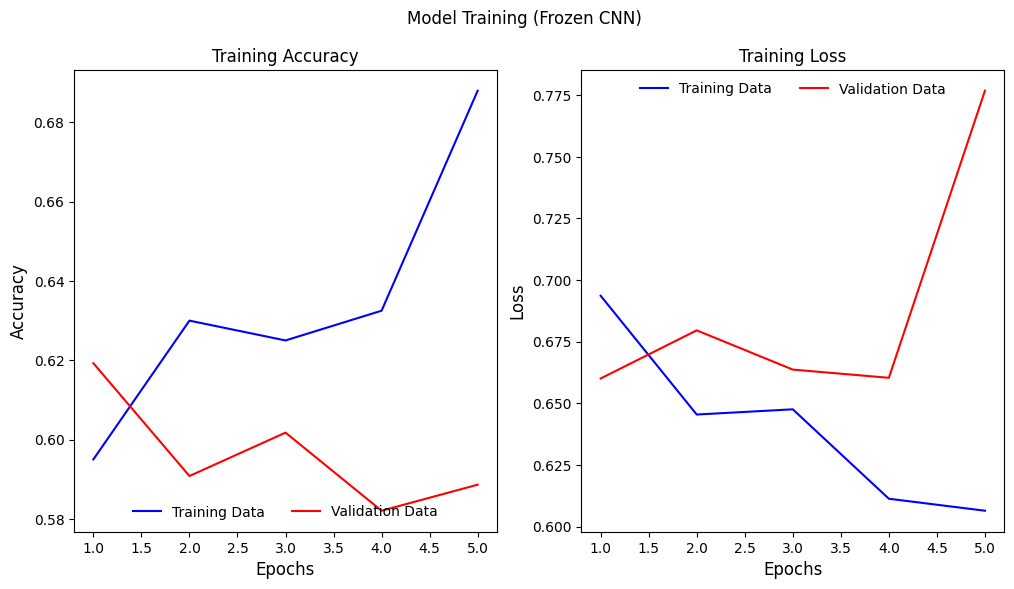

In [8]:
from matplotlib import pyplot as plt

# Plot performance
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
fig.suptitle("Model Training (Frozen CNN)", fontsize=12)
max_epoch = len(history_01.history['accuracy'])+1
epochs_list = [*range(1, max_epoch)]

ax1.plot(epochs_list, history_01.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history_01.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

ax2.plot(epochs_list, history_01.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history_01.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center', ncol=2)


In [9]:
# save model
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_01.save_weights(filepath='model_weights/vgg19_model_01.h5', overwrite=True)
# Resize test images similar to the train data
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  batch_size=1,
                                                  target_size=(240, 240),
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  seed=42,
                                                  color_mode='rgb')

Found 479 images belonging to 2 classes.


In [10]:
# Load the saved model
model_01.load_weights('model_weights/vgg19_model_01.h5')

# Evaluate the model on batches of validation and testing data
vgg_val_eval_01 = model_01.evaluate(valid_generator)
vgg_test_eval_01 = model_01.evaluate(test_generator)

479/479 [==============================] - 7s 15ms/step - loss: 0.8059 - accuracy: 0.5887


In [11]:
import numpy as np
filenames = test_generator.filenames
nb_samples = len(filenames)
vgg_predictions_01 = model_01.predict(test_generator,
                                      steps = nb_samples,
                                      verbose=1)
vgg_pred_labels_01= np.argmax(vgg_predictions_01, axis=1)

479/479 [==============================] - 7s 14ms/step


In [12]:
# Classification Report
print(classification_report(test_generator.classes, vgg_pred_labels_01, 
                            target_names=['tumorous', 'non-tumorous']))
vgg_conf_mat_01 = pd.DataFrame(confusion_matrix(test_generator.classes, vgg_pred_labels_01), 
                        index=['tumorous', 'non-tumorous'], 
                        columns=['tumorous', 'non-tumorous'])

              precision    recall  f1-score   support

    tumorous       0.87      0.17      0.29       231
non-tumorous       0.56      0.98      0.71       248

    accuracy                           0.59       479
   macro avg       0.71      0.57      0.50       479
weighted avg       0.71      0.59      0.51       479



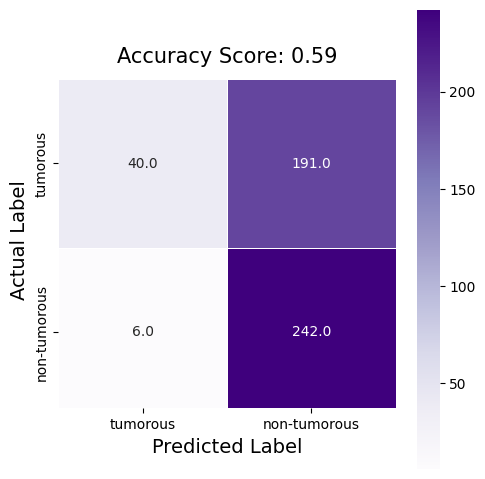

In [13]:
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(vgg_conf_mat_01, annot=True, fmt=".1f", linewidths=0.5, square=True, cmap='Purples')
ax.set_ylabel("Actual Label", fontsize=14)
ax.set_xlabel("Predicted Label", fontsize=14)
all_sample_title="Accuracy Score: {0:.2f}".format(vgg_test_eval_01[1])
ax.set_title(all_sample_title, size=15)
ax.set_ylim(len(vgg_conf_mat_01)-0.05, -0.05)
plt.tight_layout()

In [14]:
print('F1 Score: %.4f' % f1_score(test_generator.classes, vgg_pred_labels_01))

F1 Score: 0.7107


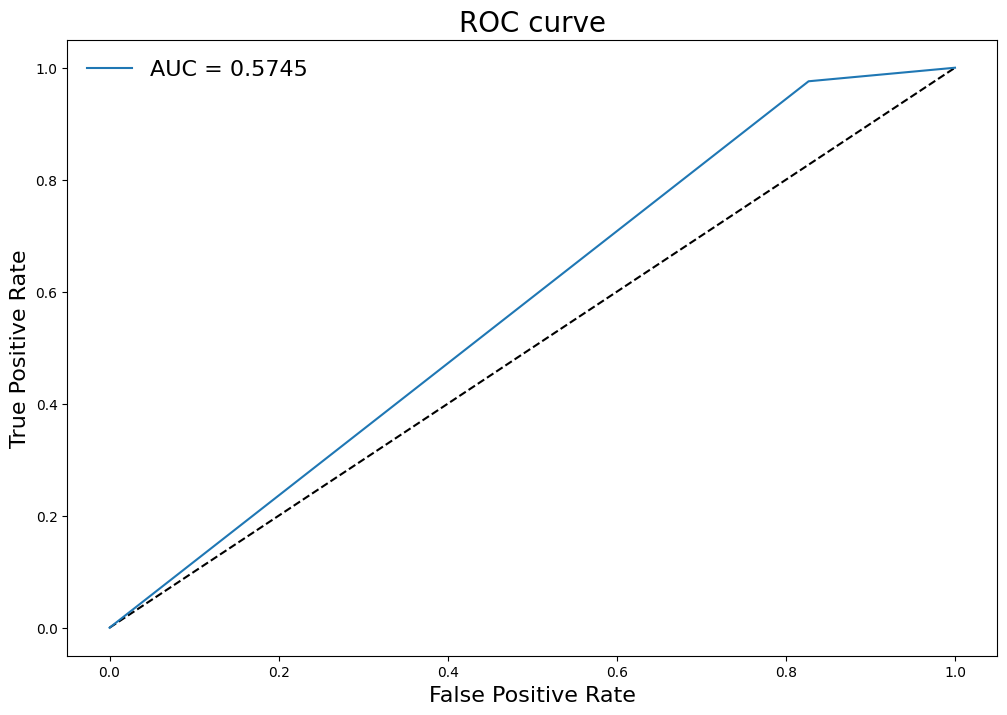

In [15]:
# AUC Curve
false_positive_rate, true_positive_rate, threshold = roc_curve(test_generator.classes, vgg_pred_labels_01)
area_under_curve = auc(false_positive_rate, true_positive_rate)

# Plot AUC Curve
fig, ax = plt.subplots(figsize=(12,8))
ax.plot([0,1], [0,1], 'k--')
ax.plot(false_positive_rate, true_positive_rate, label='AUC = {:.4f}'.format(area_under_curve))
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.set_title("ROC curve", fontsize=20)
ax.legend(frameon=False, loc='best', ncol=1, fontsize=16)

In [16]:
base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

x = base_model.output

flat=Flatten()(x)

class_1 = Dense(4608, activation='relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation='relu')(drop_out)
output = Dense(2, activation='softmax')(class_2)

model_02 = Model(base_model.inputs, output)
model_02.load_weights('model_weights/vgg19_model_01.h5')

set_trainable = False
for layer in base_model.layers:
    if layer.name in ['block5_conv4', 'block5_conv3']:
        set_trainable=True
    if set_trainable:
        layer.trainable=True
    else:
        layer.trainable=False

print(model_02.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 120, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 60, 128)       0   

In [17]:
sgd = tf.keras.optimizers.legacy.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model_02.compile(optimizer=sgd,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
history_02 = model_02.fit(train_generator, 
                          steps_per_epoch=25, 
                          epochs=10, 
                          callbacks = [es, cp, lrr], 
                          validation_data = valid_generator)

Epoch 1/10
25/25 [==============================] - ETA: 0s - loss: 0.9383 - accuracy: 0.5600
Epoch 1: val_loss did not improve from 0.66005
25/25 [==============================] - 12s 392ms/step - loss: 0.9383 - accuracy: 0.5600 - val_loss: 0.8134 - val_accuracy: 0.5055 - lr: 0.0010
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 0.6665 - accuracy: 0.6360
Epoch 2: val_loss improved from 0.66005 to 0.65784, saving model to models/model.h5
25/25 [==============================] - 15s 612ms/step - loss: 0.6665 - accuracy: 0.6360 - val_loss: 0.6578 - val_accuracy: 0.5733 - lr: 0.0010
Epoch 3/10
25/25 [==============================] - ETA: 0s - loss: 0.5929 - accuracy: 0.6760
Epoch 3: val_loss did not improve from 0.65784
25/25 [==============================] - 9s 355ms/step - loss: 0.5929 - accuracy: 0.6760 - val_loss: 0.8884 - val_accuracy: 0.5514 - lr: 0.0010
Epoch 4/10
25/25 [==============================] - ETA: 0s - loss: 0.5689 - accuracy: 0.7469
Epoch 4: val

In [18]:
# save model
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_02.save_weights(filepath='model_weights/vgg19_model_02.h5', overwrite=True)

479/479 [==============================] - 8s 16ms/step - loss: 0.8256 - accuracy: 0.6388
Validation loss:     0.7057516574859619
Validation accuracy: 0.6236323714256287
Test loss:           0.8255634903907776
Test accuracy:       0.6388309001922607
479/479 [==============================] - 7s 14ms/step
              precision    recall  f1-score   support

    tumorous       0.95      0.26      0.41       231
non-tumorous       0.59      0.99      0.74       248

    accuracy                           0.64       479
   macro avg       0.77      0.63      0.58       479
weighted avg       0.77      0.64      0.58       479



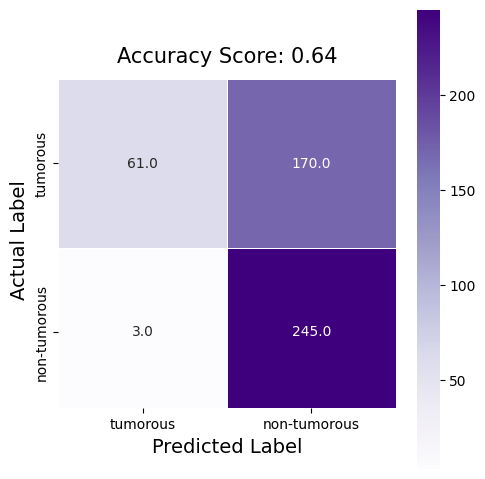

In [19]:
# Load the saved model
model_02.load_weights('model_weights/vgg19_model_02.h5')

# Evaluate the model on the hold out validation and test datasets
vgg_val_eval_02 = model_02.evaluate(valid_generator)
vgg_test_eval_02 = model_02.evaluate(test_generator)

print('Validation loss:     {}'.format(vgg_val_eval_02[0]))
print('Validation accuracy: {}'.format(vgg_val_eval_02[1]))
print('Test loss:           {}'.format(vgg_test_eval_02[0]))
print('Test accuracy:       {}'.format(vgg_test_eval_02[1]))


filenames = test_generator.filenames
nb_samples = len(filenames)
vgg_predictions_02 = model_02.predict(test_generator,
                                                steps = nb_samples,
                                                verbose=1)
vgg_pred_labels_02 = np.argmax(vgg_predictions_02, axis=1)


# Classification Report
print(classification_report(test_generator.classes, vgg_pred_labels_02, 
                            target_names=['tumorous', 'non-tumorous']))
vgg_conf_mat_02 = pd.DataFrame(confusion_matrix(test_generator.classes, vgg_pred_labels_02), 
                        index=['tumorous', 'non-tumorous'], 
                        columns=['tumorous', 'non-tumorous'])


fig, ax = plt.subplots(figsize=(5,5))

sns.heatmap(vgg_conf_mat_02, annot=True, fmt=".1f", linewidths=0.5, square=True, cmap='Purples')
ax.set_ylabel("Actual Label", fontsize=14)
ax.set_xlabel("Predicted Label", fontsize=14)
all_sample_title="Accuracy Score: {0:.2f}".format(vgg_test_eval_02[1])
ax.set_title(all_sample_title, size=15)
ax.set_ylim(len(vgg_conf_mat_02)-0.05, -0.05)
plt.tight_layout()

In [20]:
print('F1 Score: %.4f' % f1_score(test_generator.classes, vgg_pred_labels_02))


F1 Score: 0.7391


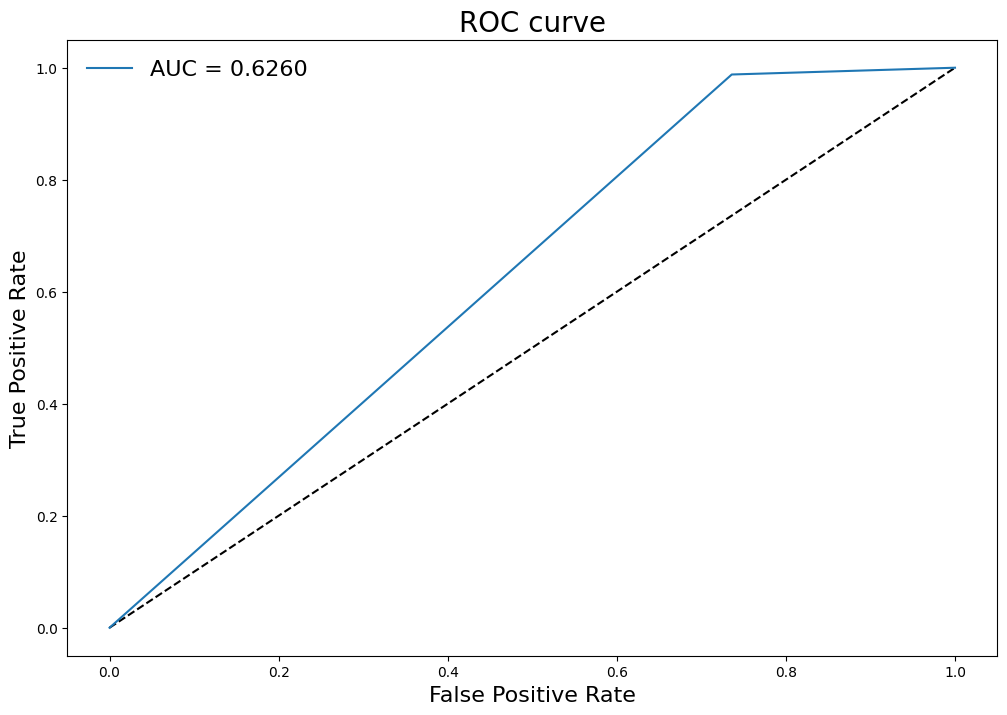

In [21]:
# AUC Curve
false_positive_rate, true_positive_rate, threshold = roc_curve(test_generator.classes, vgg_pred_labels_02)
area_under_curve = auc(false_positive_rate, true_positive_rate)

# Plot AUC Curve
fig, ax = plt.subplots(figsize=(12,8))
ax.plot([0,1], [0,1], 'k--')
ax.plot(false_positive_rate, true_positive_rate, label='AUC = {:.4f}'.format(area_under_curve))
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.set_title("ROC curve", fontsize=20)
ax.legend(frameon=False, loc='best', ncol=1, fontsize=16)

In [22]:
# Build the network
base_model = VGG19(include_top=False, input_shape=(240,240,3))
x = base_model.output
flat=Flatten()(x)
class_1 = Dense(4608, activation='relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation='relu')(drop_out)
output = Dense(2, activation='softmax')(class_2)
model_03 = Model(base_model.inputs, output)

# Load weights
model_03.load_weights('model_weights/vgg19_model_02.h5')

sgd = tf.keras.optimizers.legacy.SGD(learning_rate=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
# Compile the model
model_03.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
history_03 = model_03.fit(train_generator,
                          steps_per_epoch=80,
                          epochs=30,
                          callbacks = [es, cp, lrr],
                          validation_data = valid_generator)

Epoch 1/30
80/80 [==============================] - ETA: 0s - loss: 0.4374 - accuracy: 0.7965
Epoch 1: val_loss improved from 0.65784 to 0.44293, saving model to models/model.h5
80/80 [==============================] - 41s 463ms/step - loss: 0.4374 - accuracy: 0.7965 - val_loss: 0.4429 - val_accuracy: 0.7965 - lr: 1.0000e-04
Epoch 2/30
80/80 [==============================] - ETA: 0s - loss: 0.3993 - accuracy: 0.8344
Epoch 2: val_loss improved from 0.44293 to 0.33133, saving model to models/model.h5
80/80 [==============================] - 37s 457ms/step - loss: 0.3993 - accuracy: 0.8344 - val_loss: 0.3313 - val_accuracy: 0.8490 - lr: 1.0000e-04
Epoch 3/30
80/80 [==============================] - ETA: 0s - loss: 0.3139 - accuracy: 0.8660
Epoch 3: val_loss improved from 0.33133 to 0.19396, saving model to models/model.h5
80/80 [==============================] - 32s 404ms/step - loss: 0.3139 - accuracy: 0.8660 - val_loss: 0.1940 - val_accuracy: 0.9322 - lr: 1.0000e-04
Epoch 4/30
80/80 [=

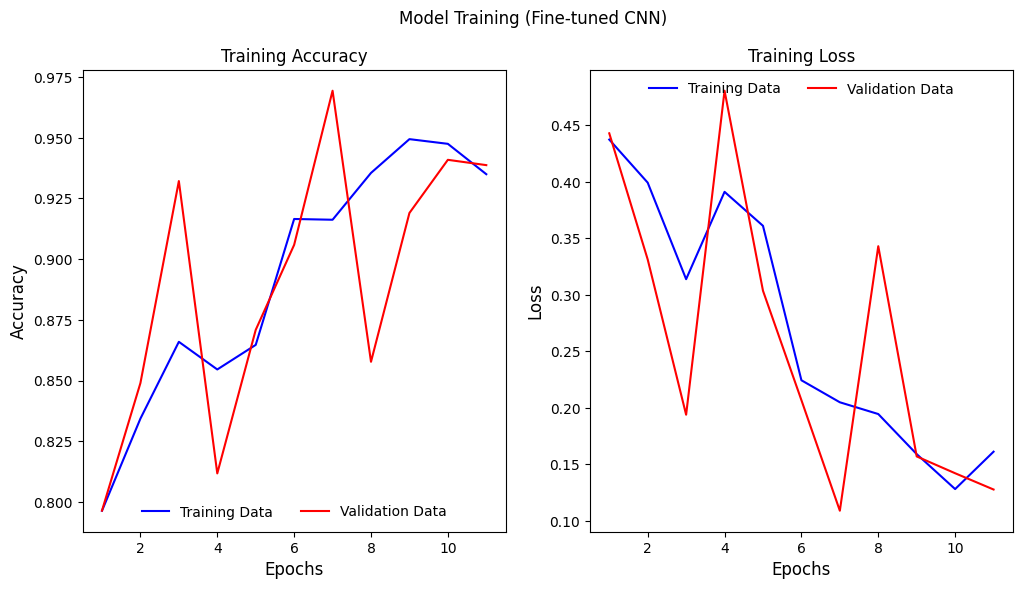

In [23]:
# New Evauation Metric
# Plot performance
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
fig.suptitle("Model Training (Fine-tuned CNN)", fontsize=12)
max_epoch = len(history_03.history['accuracy'])+1
epochs_list = [*range(1, max_epoch)]

ax1.plot(epochs_list, history_03.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history_03.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

ax2.plot(epochs_list, history_03.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history_03.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center', ncol=2)


479/479 [==============================] - 7s 15ms/step - loss: 0.4660 - accuracy: 0.9040
Validation loss     :0.1278
Validation accuracy :0.9387
Test loss           :0.4660
Test accuracy       :0.9040
479/479 [==============================] - 7s 15ms/step
              precision    recall  f1-score   support

    tumorous       0.96      0.83      0.89       231
non-tumorous       0.86      0.97      0.91       248

    accuracy                           0.90       479
   macro avg       0.91      0.90      0.90       479
weighted avg       0.91      0.90      0.90       479



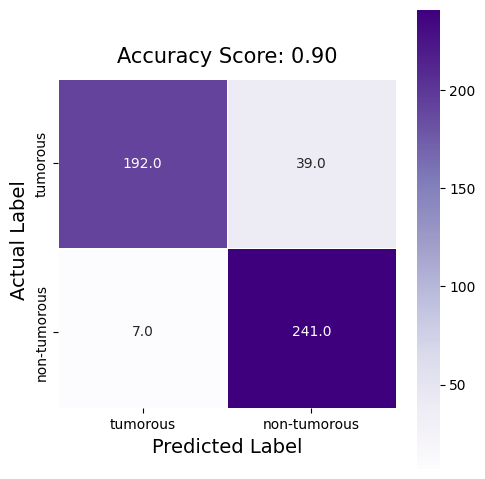

In [24]:
# save model
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_03.save_weights(filepath='model_weights/vgg_unfrozen.h5', overwrite=True)
# Load the saved model
model_03.load_weights('model_weights/vgg_unfrozen.h5')

# Evaluate the model on the hold out validation and test datasets
vgg_val_eval_03 = model_03.evaluate(valid_generator)
vgg_test_eval_03 = model_03.evaluate(test_generator)

print('Validation loss     :{0:.4f}'.format(vgg_val_eval_03[0]))
print('Validation accuracy :{0:.4f}'.format(vgg_val_eval_03[1]))
print('Test loss           :{0:.4f}'.format(vgg_test_eval_03[0]))
print('Test accuracy       :{0:.4f}'.format(vgg_test_eval_03[1]))


filenames = test_generator.filenames
nb_samples = len(filenames)
vgg_predictions_03 = model_03.predict(test_generator,
                                      steps = nb_samples,
                                      verbose=1)
vgg_pred_labels_03 = np.argmax(vgg_predictions_03, axis=1)

# Classification Report
print(classification_report(test_generator.classes, vgg_pred_labels_03, 
                            target_names=['tumorous', 'non-tumorous']))
vgg_conf_mat_03 = pd.DataFrame(confusion_matrix(test_generator.classes, vgg_pred_labels_03), 
                        index=['tumorous', 'non-tumorous'], 
                        columns=['tumorous', 'non-tumorous'])


fig, ax = plt.subplots(figsize=(5,5))

sns.heatmap(vgg_conf_mat_03, annot=True, fmt=".1f", linewidths=0.5, square=True, cmap='Purples')
ax.set_ylabel("Actual Label", fontsize=14)
ax.set_xlabel("Predicted Label", fontsize=14)
all_sample_title="Accuracy Score: {0:.2f}".format(vgg_test_eval_03[1])
ax.set_title(all_sample_title, size=15)
ax.set_ylim(len(vgg_conf_mat_03)-0.05, -0.05)
plt.tight_layout()

In [25]:
print('F1 Score: %.4f' % f1_score(test_generator.classes, vgg_pred_labels_03))


F1 Score: 0.9129


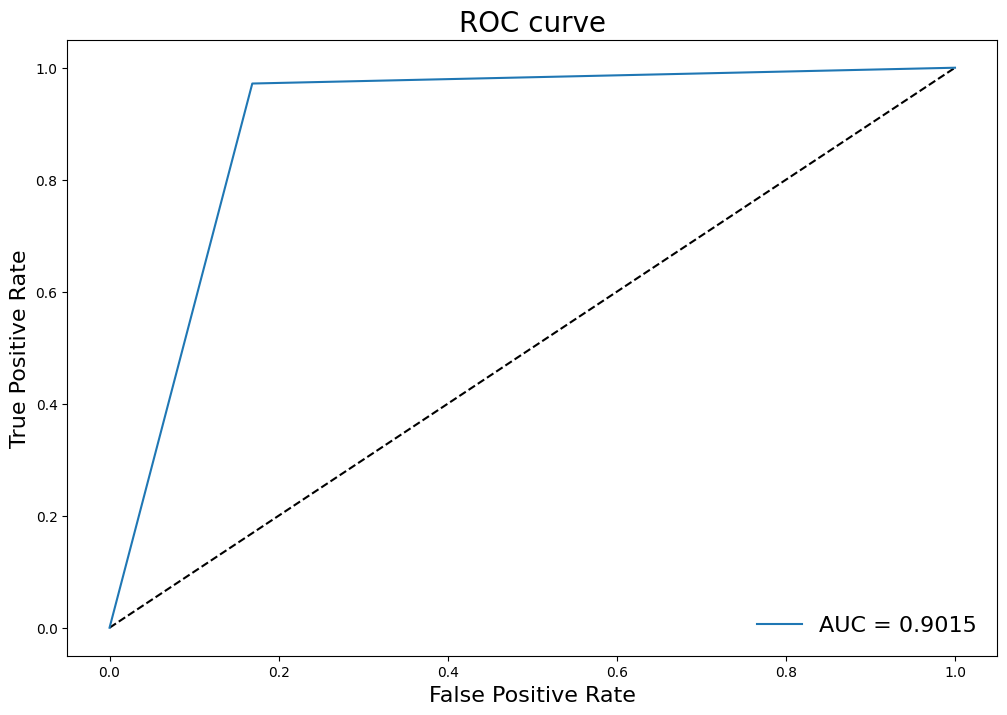

In [26]:
# AUC Curve
false_positive_rate, true_positive_rate, threshold = roc_curve(test_generator.classes, vgg_pred_labels_03)
area_under_curve = auc(false_positive_rate, true_positive_rate)

# Plot AUC Curve
fig, ax = plt.subplots(figsize=(12,8))
ax.plot([0,1], [0,1], 'k--')
ax.plot(false_positive_rate, true_positive_rate, label='AUC = {:.4f}'.format(area_under_curve))
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.set_title("ROC curve", fontsize=20)
ax.legend(frameon=False, loc='best', ncol=1, fontsize=16)

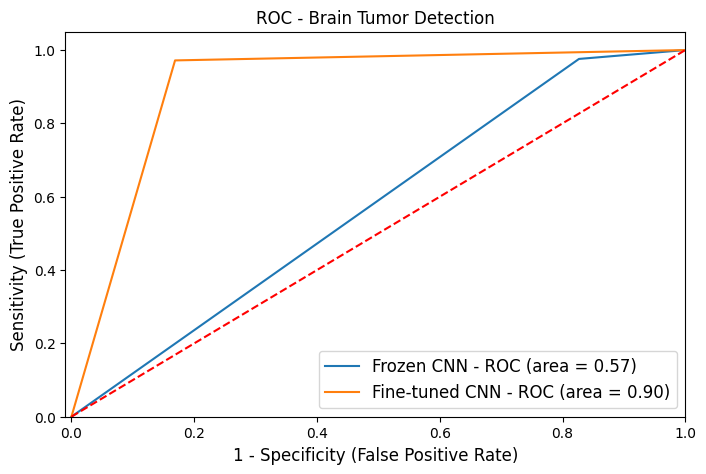

In [27]:
from sklearn import metrics
plt.figure(figsize=(8,5))
models = [
{
    'label': 'Frozen CNN',
    'model': model_01,
    'roc': vgg_pred_labels_01,
},
{
    'label': 'Fine-tuned CNN',
    'model': model_03,
    'roc': vgg_pred_labels_03,
}
]
for m in models:
    model = m['model']  
    false_positive_rate, true_positive_rate, threshold = roc_curve(test_generator.classes, m['roc'])
    area_under_curve = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, 
             label='%s - ROC (area = %0.2f)' % (m['label'], area_under_curve))

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity (False Positive Rate)', fontsize=12)
plt.ylabel('Sensitivity (True Positive Rate)', fontsize=12)
plt.title('ROC - Brain Tumor Detection', fontsize=12)
plt.legend(loc="lower right", fontsize=12)


In [28]:
model_name = "brain_tumor_detection"
model_version = "0001"
model_path = os.path.join(model_name, model_version)
model.save(model_path, save_format="tf")

In [29]:
!zip -r /content/data.zip /content/brain_tumor_detection

  adding: content/brain_tumor_detection/ (stored 0%)
  adding: content/brain_tumor_detection/0001/ (stored 0%)
  adding: content/brain_tumor_detection/0001/assets/ (stored 0%)
  adding: content/brain_tumor_detection/0001/saved_model.pb (deflated 90%)
  adding: content/brain_tumor_detection/0001/fingerprint.pb (stored 0%)
  adding: content/brain_tumor_detection/0001/variables/ (stored 0%)
  adding: content/brain_tumor_detection/0001/variables/variables.index (deflated 76%)
  adding: content/brain_tumor_detection/0001/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/brain_tumor_detection/0001/keras_metadata.pb (deflated 95%)
